In [1]:
import socket, sys
socket.gethostname(), sys.executable


('fc11005', '/project/def-nahee/kbas/pone_offline/graphnet_env/bin/python')

## Imports


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 0) Notes & configuration


- Energy model prediction is in log10-space.


### File paths


In [ ]:
energy_test_predictions_path = Path("energy") / "test_predictions.csv"
zenith_test_predictions_path = Path("zenith") / "test_predictions.csv"
azimuth_test_predictions_path = Path("azimuth") / "test_predictions.csv"



energy_metrics_path = Path("energy") / "metrics.csv"
zenith_metrics_path = Path("zenith") / "metrics.csv"
azimuth_metrics_path = Path("azimuth") / "metrics.csv"



df_energy_test_predictions = pd.read_csv(energy_test_predictions_path)
df_zenith_test_predictions = pd.read_csv(zenith_test_predictions_path)
df_azimuth_test_predictions = pd.read_csv(azimuth_test_predictions_path)


## 1) test_predictions.csv


### 1.a) Energy


Flow:
1) Confirm columns / NaNs / Infs.
2) Look at the global residual histogram.
3) Check residual vs true energy (trend + spread).
4) Quantify resolution with **W** (both equal-width and equal-population bins).
5) Assess bias with median residual and pred/true ratio.


In [ ]:
print("shape:", df_energy_test_predictions.shape)
print("columns:", list(df_energy_test_predictions.columns))

shape: (41311, 5)
columns: ['true_energy', 'pred_log10_energy', 'pred_energy', 'residual_log10', 'event_id']


In [ ]:
df_energy_test_predictions["true_log10_energy"] = np.log10(df_energy_test_predictions["true_energy"].astype(float))

In [ ]:
df_energy_test_predictions.head(3)

,true_energy,pred_log10_energy,pred_energy,residual_log10,event_id,true_log10_energy
0,108859.773438,3.031981,1076.417480,-2.004887,242,5.036867
1,14684.890625,4.300442,19972.949219,0.133572,778,4.166871
2,127.363152,2.352156,224.986465,0.247113,1171,2.105044


In [ ]:
print("Rows:", len(df_energy_test_predictions))

print("\nNaN counts (all columns):")
print(df_energy_test_predictions.isna().sum())


Rows: 41311

NaN counts (all columns):
true_energy          0
pred_log10_energy    0
pred_energy          0
residual_log10       0
event_id             0
true_log10_energy    0
dtype: int64


In [ ]:
# Inf / -Inf counts in numeric columns (auto)
num_df = df_energy_test_predictions.apply(pd.to_numeric, errors="coerce")

inf_pos = np.isposinf(num_df).sum()
inf_neg = np.isneginf(num_df).sum()
inf_any = np.isinf(num_df).sum()

out = pd.DataFrame({
    "+inf": inf_pos,
    "-inf": inf_neg,
    "any_inf": inf_any
}).sort_values("any_inf", ascending=False)

print("Inf counts (numeric columns):")
print(out)


Inf counts (numeric columns):
                   +inf  -inf  any_inf
true_energy           0     0        0
pred_log10_energy     0     0        0
pred_energy           0     0        0
residual_log10        0     0        0
event_id              0     0        0
true_log10_energy     0     0        0


In [ ]:
# true_energy <= 0 check 
true_e = pd.to_numeric(df_energy_test_predictions["true_energy"], errors="coerce")
print("\ntrue_energy <= 0:", (true_e <= 0).sum())


true_energy <= 0: 0


#### Energy overview

In [ ]:
# ---- Energy: global W over the full test set ----
r = df_energy_test_predictions["residual_log10"].to_numpy(dtype=float)
p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
W = (p84 - p16) / 2

print(f"p16={p16:.4f}, p50={p50:.4f}, p84={p84:.4f}, W={W:.4f}")

p16=-0.3470, p50=0.0275, p84=0.3172, W=0.3321


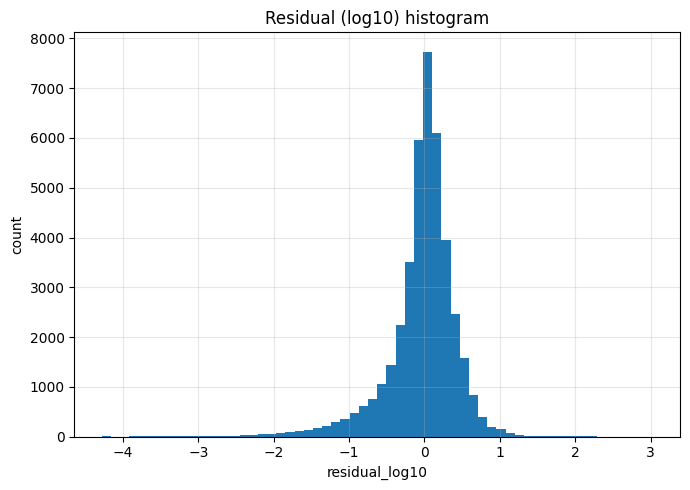

In [ ]:
# ---- Energy: residual_log10 histogram (full test set) ----

plt.figure(figsize=(7, 5))
plt.hist(r, bins=60)
plt.xlabel("residual_log10")
plt.ylabel("count")
plt.title("Residual (log10) histogram")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Residual vs true energy (with binned median)

This diagnostic shows how the **log10 residual** behaves across the energy range:

- Each blue point is one event:  
  $r = \widehat{\log_{10}E} - \log_{10}(E_\mathrm{true})$  
- The horizontal line at $r=0$ is the **ideal** case (no bias).
- The red curve is the **binned median** of the residual, which highlights the typical trend.

What to look for:
- If the red curve stays near 0 → the model is **well-calibrated** across energies.
- If it drifts above 0 → systematic **overestimation**.
- If it drifts below 0 → systematic **underestimation**.
- If the vertical spread increases with energy → **worsening resolution** (larger event-to-event scatter).



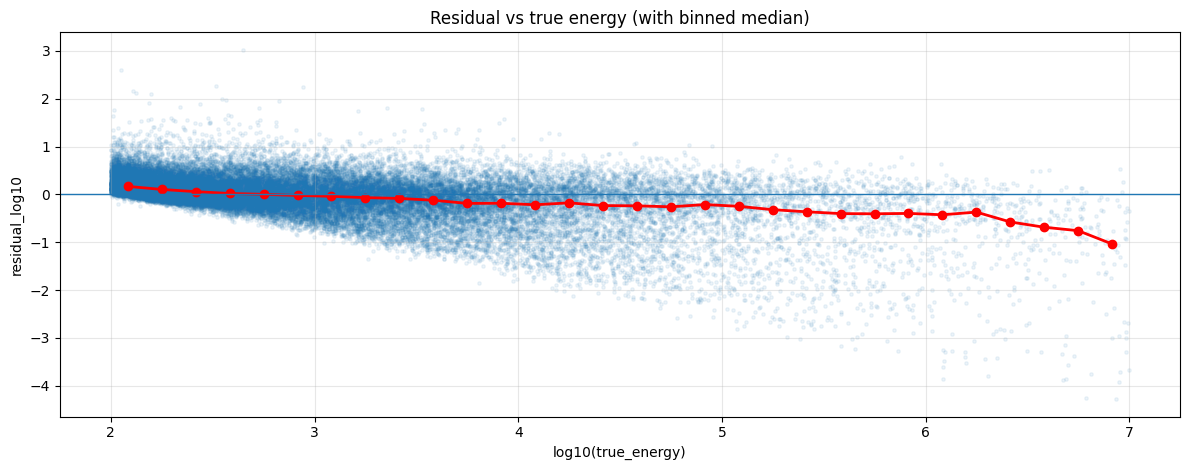

In [ ]:
# ---- Energy: residual vs true_log10_energy scatter + binned median ----

x = df_energy_test_predictions["true_log10_energy"].to_numpy(dtype=float)
r = df_energy_test_predictions["residual_log10"].to_numpy(dtype=float)

plt.figure(figsize=(12, 4.8))
plt.scatter(x, r, s=6, alpha=0.08)

# binned median (equal-width in x)
n_bins = 30
bins = np.linspace(x.min(), x.max(), n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

median_r = []
for left, right in zip(bins[:-1], bins[1:]):
    m = (x >= left) & (x < right) if right != bins[-1] else (x >= left) & (x <= right)
    median_r.append(np.median(r[m]) if np.any(m) else np.nan)

median_r = np.array(median_r, dtype=float)

# plot median curve
plt.plot(bin_centers, median_r, marker="o", linewidth=2, color="r")

# reference line
plt.axhline(0.0, linestyle="-", linewidth=1)

plt.xlabel("log10(true_energy)")
plt.ylabel("residual_log10")
plt.title("Residual vs true energy (with binned median)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### Calibration scatter (predicted vs true)

A calibration plot compares the model prediction to the truth directly:

- x-axis: $\log_{10}(E_\mathrm{true})$  
- y-axis: $\widehat{\log_{10}E}$

The reference line $y=x$ corresponds to perfect calibration.
Points below the line indicate underestimation; above the line indicate overestimation.


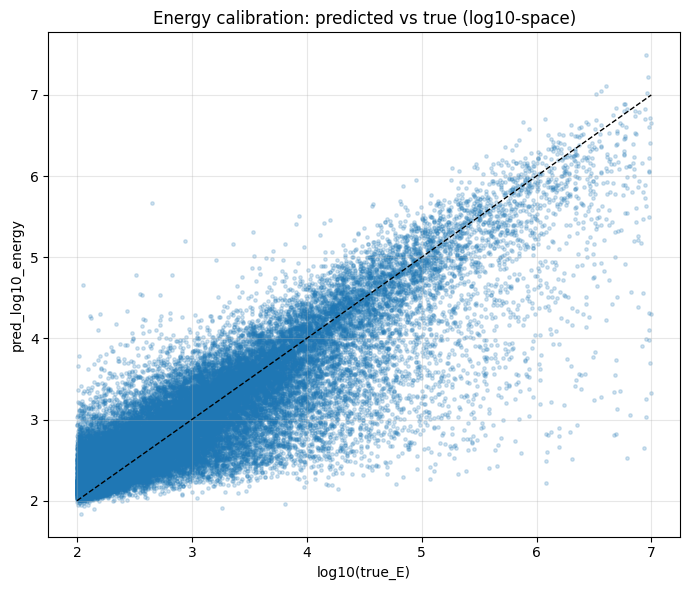

In [ ]:
# ---- Energy: calibration scatter (pred_log10 vs true_log10) ----

plt.figure(figsize=(7, 6))  # bigger figure

plt.scatter(
    df_energy_test_predictions["true_log10_energy"],
    df_energy_test_predictions["pred_log10_energy"],
    s=6, alpha=0.2
)

xmin = df_energy_test_predictions["true_log10_energy"].min()
xmax = df_energy_test_predictions["true_log10_energy"].max()

plt.plot([xmin, xmax], [xmin, xmax], color="black", linestyle="--", linewidth=1)  # y=x in black

plt.xlabel("log10(true_E)")
plt.ylabel("pred_log10_energy")
plt.title("Energy calibration: predicted vs true (log10-space)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


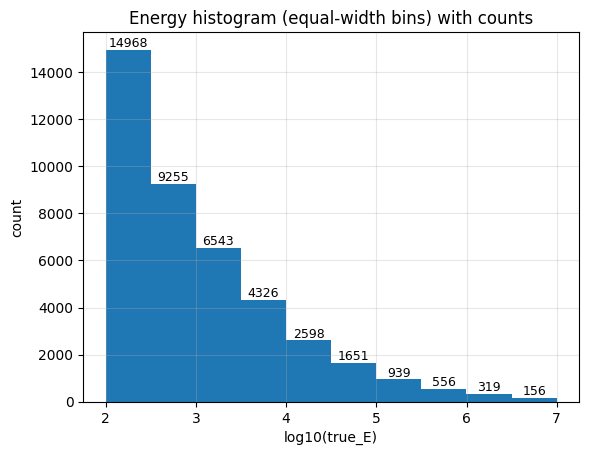

In [ ]:
# ---- Energy: histogram with counts annotated on top of bars ----
n_bins_energy = 10
bins_energy = np.linspace(
    df_energy_test_predictions["true_log10_energy"].min(),
    df_energy_test_predictions["true_log10_energy"].max(),
    n_bins_energy + 1,
)
values = df_energy_test_predictions["true_log10_energy"].to_numpy()

plt.figure()
counts, edges, patches = plt.hist(values, bins=bins_energy)

# annotate each bar with its count
for c, left, right in zip(counts, edges[:-1], edges[1:]):
    if c <= 0:
        continue
    x = 0.5 * (left + right)
    plt.text(x, c, f"{int(c)}", ha="center", va="bottom", fontsize=9)

plt.xlabel("log10(true_E)")
plt.ylabel("count")
plt.title("Energy histogram (equal-width bins) with counts")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
df_energy_w_rows = []
for left, right in zip(edges[:-1], edges[1:]):
    # select events in this bin (match matplotlib hist logic: [left, right) except last bin includes right)
    if right == edges[-1]:
        mask = (df_energy_test_predictions["true_log10_energy"] >= left) & (df_energy_test_predictions["true_log10_energy"] <= right)
    else:
        mask = (df_energy_test_predictions["true_log10_energy"] >= left) & (df_energy_test_predictions["true_log10_energy"] < right)

    r = df_energy_test_predictions.loc[mask, "residual_log10"].to_numpy(dtype=float)

    # skip empty bins (shouldn't happen, but safe)
    if r.size == 0:
        continue

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (left + right)

    df_energy_w_rows.append({
        "Ebin": f"({left:.3f}, {right:.3f}]",
        "E_center_log10": center,
        "count": int(r.size),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,
    })

df_energy_W_table = pd.DataFrame(df_energy_w_rows)
df_energy_W_table


,Ebin,E_center_log10,count,p16,p50,p84,W
0,"(2.000, 2.500]",2.249981,14968,-0.035715,0.123847,0.389871,0.212793
1,"(2.500, 3.000]",2.749870,9255,-0.238682,0.004964,0.315503,0.277093
2,"(3.000, 3.500]",3.249758,6543,-0.483135,-0.061241,0.270746,0.376940
3,"(3.500, 4.000]",3.749646,4326,-0.715296,-0.153390,0.206191,0.460743
4,"(4.000, 4.499]",4.249534,2598,-0.999501,-0.209636,0.205782,0.602641
5,"(4.499, 4.999]",4.749422,1651,-1.190253,-0.236889,0.204971,0.697612
6,"(4.999, 5.499]",5.249311,939,-1.417254,-0.301551,0.163690,0.790472
7,"(5.499, 5.999]",5.749199,556,-1.628825,-0.402337,0.070917,0.849871
8,"(5.999, 6.499]",6.249087,319,-1.695658,-0.478368,-0.022340,0.836659
9,"(6.499, 6.999]",6.748975,156,-2.370998,-0.844405,-0.144696,1.113151


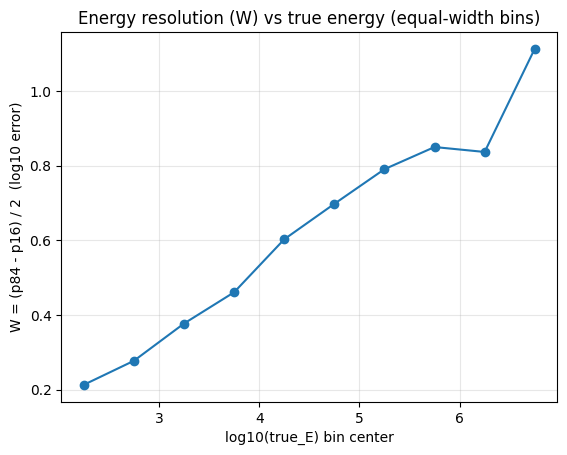

In [ ]:
# ---- Energy: plot W vs true energy (equal-width bins) ----

plt.figure()
plt.plot(df_energy_W_table["E_center_log10"], df_energy_W_table["W"], marker="o")
plt.xlabel("log10(true_E) bin center")
plt.ylabel("W = (p84 - p16) / 2  (log10 error)")
plt.title("Energy resolution (W) vs true energy (equal-width bins)")
plt.grid(True, alpha=0.3)
plt.show()


#### Interpreting the W trend (equal-width bins)

In the **equal-width** energy binning, the number of events per bin is **not uniform**.  
At higher energies the bins contain **much fewer events**, so the quantile estimates (p16/p50/p84) become **statistically unstable**. This can artificially inflate the width  
$W = (p84 - p16)/2$ and make it look like the resolution worsens rapidly with energy.

To reduce this sampling effect, we next repeat the same analysis using **equal-population bins** (i.e., bins with approximately the same number of events) and compare the results.


In [ ]:
# ---- create equal-population bins (qcut) ----

n_qbins_energy = 10

df_energy_test_predictions["Ebin_q"] = pd.qcut(
    df_energy_test_predictions["true_log10_energy"],
    q=n_qbins_energy,
    duplicates="drop",
)


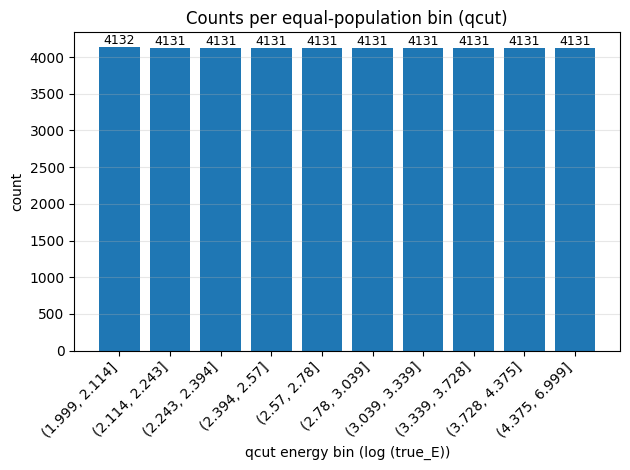

In [ ]:
# ----  plot counts per qcut bin ----

bin_counts_q = df_energy_test_predictions["Ebin_q"].value_counts().sort_index()

plt.figure()
bars = plt.bar(range(len(bin_counts_q)), bin_counts_q.to_numpy())
plt.xticks(range(len(bin_counts_q)), [str(i) for i in bin_counts_q.index], rotation=45, ha="right")
plt.xlabel("qcut energy bin (log (true_E))")
plt.ylabel("count")
plt.title("Counts per equal-population bin (qcut)")
plt.grid(True, axis="y", alpha=0.3)

# annotate counts on top of bars
for i, c in enumerate(bin_counts_q.to_numpy()):
    plt.text(i, c, str(int(c)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


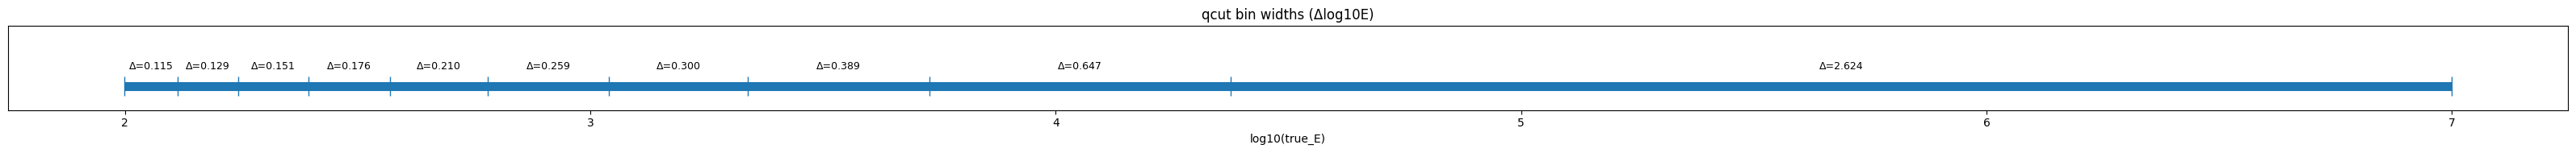

In [ ]:
# ---- Visualize qcut bin widths only (in log10-space) ----

# intervals in correct order
intervals = bin_counts_q.index  # IntervalIndex from your existing bin_counts_q

lefts  = np.array([iv.left for iv in intervals], dtype=float)
rights = np.array([iv.right for iv in intervals], dtype=float)
widths = rights - lefts
centers = (lefts + rights) / 2

plt.figure(figsize=(32, 2))

# draw each bin as a horizontal segment
for L, R, w, x in zip(lefts, rights, widths, centers):
    plt.hlines(0, L, R, linewidth=8)
    plt.text(x, 0.12, f"Δ={w:.3f}", ha="center", va="bottom", fontsize=9)

# draw bin boundaries as small ticks
for x in lefts:
    plt.vlines(x, -0.08, 0.08, linewidth=1)
plt.vlines(rights[-1], -0.08, 0.08, linewidth=1)

plt.yticks([])
plt.xlabel("log10(true_E)")
plt.title("qcut bin widths (Δlog10E)")
plt.ylim(-0.2, 0.5)
plt.tight_layout()
plt.show()


In [ ]:
# ---- Energy: p16/p50/p84 and W per qcut bin (use groupby directly; no remasking) ----

rows_energy_q = []
for iv, g in df_energy_test_predictions.groupby("Ebin_q", observed=True):
    r = g["residual_log10"].to_numpy(dtype=float)

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (float(iv.left) + float(iv.right))

    rows_energy_q.append({
        "Ebin_q": str(iv),
        "E_center_log10": center,
        "count": int(len(g)),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,
    })

df_energy_W_table_q = pd.DataFrame(rows_energy_q).sort_values("E_center_log10")
df_energy_W_table_q


,Ebin_q,E_center_log10,count,p16,p50,p84,W
0,"(1.999, 2.114]",2.0565,4132,0.056936,0.176738,0.456620,0.199842
1,"(2.114, 2.243]",2.1785,4131,-0.015462,0.129529,0.396555,0.206008
2,"(2.243, 2.394]",2.3185,4131,-0.078490,0.080982,0.343818,0.211154
3,"(2.394, 2.57]",2.4820,4131,-0.135168,0.042675,0.327606,0.231387
4,"(2.57, 2.78]",2.6750,4131,-0.212629,0.013031,0.327431,0.270030
5,"(2.78, 3.039]",2.9095,4131,-0.323910,-0.020621,0.307373,0.315642
6,"(3.039, 3.339]",3.1890,4131,-0.465011,-0.056316,0.286789,0.375900
7,"(3.339, 3.728]",3.5335,4131,-0.619430,-0.108638,0.216331,0.417880
8,"(3.728, 4.375]",4.0515,4131,-0.873468,-0.192911,0.204296,0.538882
9,"(4.375, 6.999]",5.6870,4131,-1.341285,-0.303657,0.154052,0.747669


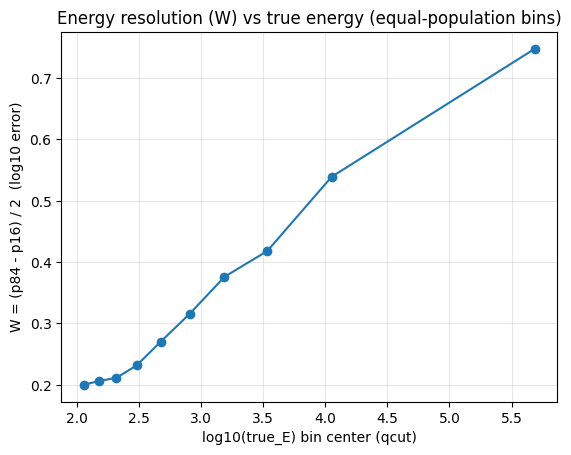

In [ ]:
# ---- Energy: plot W vs true energy (qcut bins) ----

plt.figure()
plt.plot(df_energy_W_table_q["E_center_log10"], df_energy_W_table_q["W"], marker="o")
plt.xlabel("log10(true_E) bin center (qcut)")
plt.ylabel("W = (p84 - p16) / 2  (log10 error)")
plt.title("Energy resolution (W) vs true energy (equal-population bins)")
plt.grid(True, alpha=0.3)
plt.show()


#### Why `residual_log10`?

I analyze the prediction error in **log10-space** using `residual_log10`.  
This is especially convenient when the energy spans many orders of magnitude.


#### Definition of `residual_log10`

`residual_log10` is defined as:

$ \mathrm{residual\_log10} = \widehat{\log_{10}E} - \log_{10}(E_\mathrm{true}) $

In the CSV this corresponds to:

$ \mathrm{residual\_log10} = \mathrm{pred\_log10\_energy} - \log_{10}(\mathrm{true\_energy}) $


#### Interpreting the sign of `residual_log10`

- `residual_log10 = 0` → perfect prediction  
- `residual_log10 > 0` → the model **overpredicts** energy  
- `residual_log10 < 0` → the model **underpredicts** energy


#### Quantiles: p16, p50, p84

To summarize the distribution of `residual_log10`:

- **p50** = median (middle value) → can be interpreted as **bias**
- **p16** and **p84** = the 16th and 84th percentiles  
  (If the residuals were Gaussian, these would roughly correspond to **±1σ** around the median.)


#### Resolution proxy: W

I define a resolution-like width using the central 68% interval:

$ W = \frac{p84 - p16}{2} $

Interpretation:
- **Small W** → tighter residual distribution → **better resolution**
- **Large W** → wider residual distribution → **worse resolution**

**Note:** W is measured in **log10-error units**, not directly in “% error”.


#### Energy performance so far: resolution (W)

So far we focused on **resolution**, summarized by  
$W = (p84 - p16)/2$, computed from the `residual_log10` distribution in each energy bin.

Resolution tells us **how wide** the error distribution is.

Next, we examine **bias**:  
Does the model systematically **overestimate** or **underestimate** the energy, and does this depend on energy?


#### Bias analysis — three complementary views

There are three simple and complementary ways to study bias:

1) **Median residual vs energy**  
   Plot $p50(\mathrm{residual\_log10})$ as a function of energy.  
   This is the most direct bias measure in log-space.

2) **Median pred/true ratio vs energy**  
   Convert the median residual into a multiplicative ratio  
   $\mathrm{median}(E_\mathrm{pred}/E_\mathrm{true}) = 10^{p50}$  
   to make the bias more intuitive.


#### 1) Median residual vs energy (log-space bias)

If we define  
$\mathrm{residual\_log10} = \widehat{\log_{10}E} - \log_{10}(E_\mathrm{true})$,

then:

- $p50 \approx 0$ → unbiased in that energy region  
- $p50 > 0$ → overestimation  
- $p50 < 0$ → underestimation


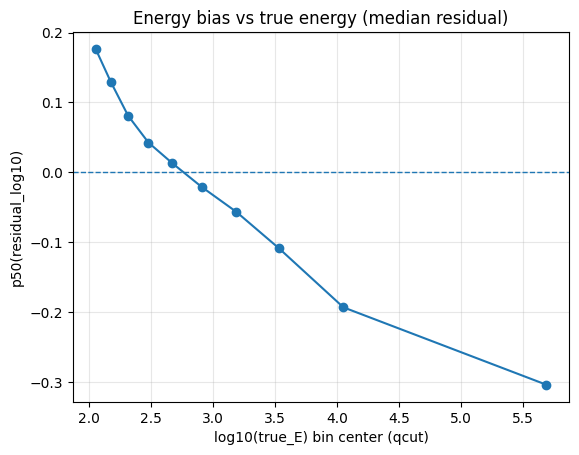

In [ ]:
# ---- Energy: bias vs true energy (median residual, qcut bins) ----

plt.figure()
plt.plot(df_energy_W_table_q["E_center_log10"], df_energy_W_table_q["p50"], marker="o")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("log10(true_E) bin center (qcut)")
plt.ylabel("p50(residual_log10)")
plt.title("Energy bias vs true energy (median residual)")
plt.grid(True, alpha=0.3)
plt.show()

#### 2) Median pred/true ratio vs energy (intuitive bias)

Because the residual is in log10-space, it can be converted into a multiplicative ratio:

$ \frac{E_\mathrm{pred}}{E_\mathrm{true}} = 10^{\mathrm{residual\_log10}} $

So the median bias ratio per bin is:

$ \mathrm{median}(E_\mathrm{pred}/E_\mathrm{true}) = 10^{p50} $

Interpretation:
- ratio ≈ 1 → unbiased
- ratio < 1 → underestimation
- ratio > 1 → overestimation


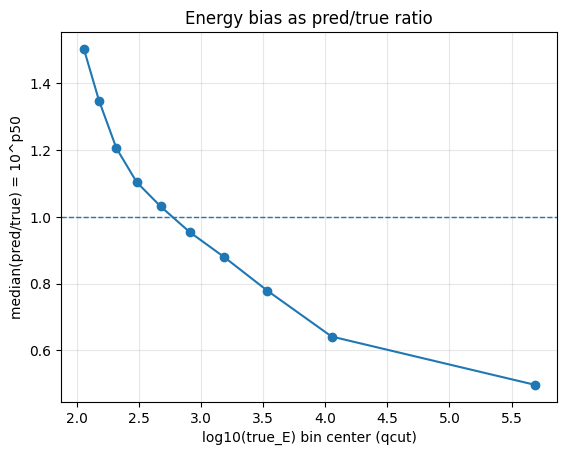

In [ ]:
# ---- Energy: bias as pred/true ratio (qcut bins) ----

df_energy_W_table_q["ratio50"] = 10 ** (df_energy_W_table_q["p50"])

plt.figure()
plt.plot(df_energy_W_table_q["E_center_log10"], df_energy_W_table_q["ratio50"], marker="o")
plt.axhline(1.0, linestyle="--", linewidth=1)
plt.xlabel("log10(true_E) bin center (qcut)")
plt.ylabel("median(pred/true) = 10^p50")
plt.title("Energy bias as pred/true ratio")
plt.grid(True, alpha=0.3)
plt.show()


### 1.b) Zenith

Flow:
1) Confirm columns / NaNs / Infs.
2) Look at the global residual histogram.
3) Check residual vs true energy (trend + spread).
4) Quantify resolution with **W** (both equal-width and equal-population bins).
5) Assess bias with median residual and pred/true ratio.


In [ ]:
print("shape:", df_zenith_test_predictions.shape)
print("columns:", list(df_zenith_test_predictions.columns))

shape: (41311, 5)
columns: ['true_zenith', 'pred_zenith', 'abs_error_deg', 'kappa', 'event_id']


In [ ]:
numeric_cols = df_zenith_test_predictions.select_dtypes(include=[np.number]).columns
minmax = df_zenith_test_predictions[numeric_cols].agg(["min", "max"]).T

print(minmax)

                     min            max
true_zenith     0.005549       3.129967
pred_zenith     0.053634       3.119514
abs_error_deg   0.000014     121.741241
kappa           1.244967     120.558090
event_id       18.000000  402910.000000


##### Column ranges (min / max)

The table above reports the **minimum** and **maximum** value observed in each **numeric** column of `df_zenith_test_predictions`.

**Units**
- `true_zenith` and `pred_zenith` are in **radians** (expected physical range: \[0, π\]).
- `abs_error_deg` is in **degrees**.
- `kappa` is **dimensionless** (concentration parameter).
- `event_id` is an **integer identifier** (unitless).

In [ ]:
# --- 1) Rename radian columns to make units explicit ---
rename_map = {
    "true_zenith": "true_zenith_radian",
    "pred_zenith": "pred_zenith_radian",
    "kappa": "kappa",          # unchanged (unitless)
    "event_id": "event_id",    # unchanged
    "abs_error_deg": "abs_error_zenith_degree",  # already in degrees
}
df_zenith_test_predictions.rename(columns={k: v for k, v in rename_map.items() if k in df_zenith_test_predictions.columns}, inplace=True)

# --- 2) Compute signed residual in radians ---
df_zenith_test_predictions["residual_zenith_radian"] = df_zenith_test_predictions["pred_zenith_radian"] - df_zenith_test_predictions["true_zenith_radian"]

# --- 3) Create degree versions ---
rad2deg = 180.0 / np.pi
df_zenith_test_predictions["true_zenith_degree"] = df_zenith_test_predictions["true_zenith_radian"] * rad2deg
df_zenith_test_predictions["pred_zenith_degree"] = df_zenith_test_predictions["pred_zenith_radian"] * rad2deg
df_zenith_test_predictions["residual_zenith_degree"] = df_zenith_test_predictions["residual_zenith_radian"] * rad2deg

# Optional: also keep abs error in radians (consistent pair with abs_error_zenith_degree)
df_zenith_test_predictions["abs_error_zenith_radian"] = np.abs(df_zenith_test_predictions["residual_zenith_radian"])

# abs error of zenith angle in radians (|pred - true|)
df_zenith_test_predictions["abs_error_zenith_radian"] = np.abs(
    df_zenith_test_predictions["pred_zenith_radian"] - df_zenith_test_predictions["true_zenith_radian"]
)

# quick check
print("columns:", list(df_zenith_test_predictions.columns))
df_zenith_test_predictions.head()


columns: ['true_zenith_radian', 'pred_zenith_radian', 'abs_error_zenith_degree', 'kappa', 'event_id', 'residual_zenith_radian', 'true_zenith_degree', 'pred_zenith_degree', 'residual_zenith_degree', 'abs_error_zenith_radian']


,true_zenith_radian,pred_zenith_radian,abs_error_zenith_degree,kappa,event_id,residual_zenith_radian,true_zenith_degree,pred_zenith_degree,residual_zenith_degree,abs_error_zenith_radian
0,0.390769,1.113049,41.383644,8.293178,242,0.722281,22.389387,63.773032,41.383645,0.722281
1,1.441897,1.440086,0.103778,99.067955,778,-0.001811,82.614621,82.510844,-0.103778,0.001811
2,1.758793,1.744501,0.818919,89.692795,1171,-0.014293,100.771443,99.952524,-0.818919,0.014293
3,2.018402,2.077291,3.374086,94.350357,1634,0.058889,115.645908,119.019994,3.374086,0.058889
4,0.521355,0.350702,9.777667,77.596909,3741,-0.170652,29.871426,20.093759,-9.777667,0.170652


In [ ]:
print("Rows:", len(df_zenith_test_predictions))

print("\nNaN counts (all columns):")
print(df_zenith_test_predictions.isna().sum())

Rows: 41311

NaN counts (all columns):
true_zenith_radian         0
pred_zenith_radian         0
abs_error_zenith_degree    0
kappa                      0
event_id                   0
residual_zenith_radian     0
true_zenith_degree         0
pred_zenith_degree         0
residual_zenith_degree     0
abs_error_zenith_radian    0
dtype: int64


In [ ]:
# Inf / -Inf counts in numeric columns (auto)
num_df = df_zenith_test_predictions.apply(pd.to_numeric, errors="coerce")

inf_pos = np.isposinf(num_df).sum()
inf_neg = np.isneginf(num_df).sum()
inf_any = np.isinf(num_df).sum()

out = pd.DataFrame({
    "+inf": inf_pos,
    "-inf": inf_neg,
    "any_inf": inf_any
}).sort_values("any_inf", ascending=False)

print("Inf counts (numeric columns):")
print(out)

Inf counts (numeric columns):
                         +inf  -inf  any_inf
true_zenith_radian          0     0        0
pred_zenith_radian          0     0        0
abs_error_zenith_degree     0     0        0
kappa                       0     0        0
event_id                    0     0        0
residual_zenith_radian      0     0        0
true_zenith_degree          0     0        0
pred_zenith_degree          0     0        0
residual_zenith_degree      0     0        0
abs_error_zenith_radian     0     0        0


#### Zenith overview

In [ ]:
# ---- Energy: global W over the full test set ----
r = df_zenith_test_predictions["residual_zenith_degree"].to_numpy(dtype=float)
p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
W = (p84 - p16) / 2

print(f"p16={p16:.4f}, p50={p50:.4f}, p84={p84:.4f}, W={W:.4f}")

p16=-3.1469, p50=0.2216, p84=3.6331, W=3.3900


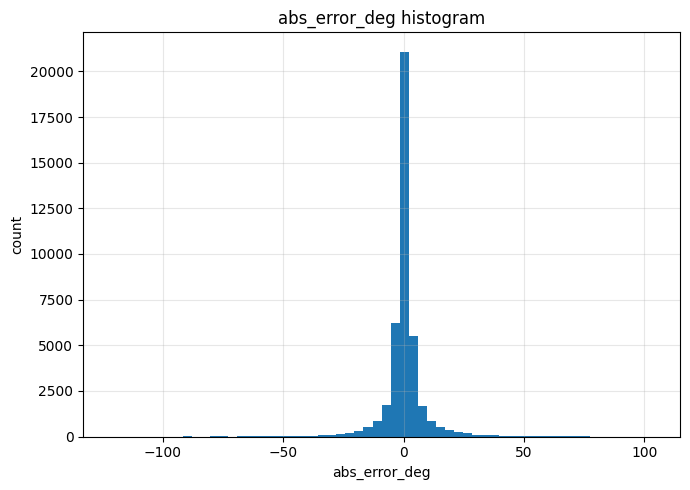

In [ ]:
# ---- abs_error_deg histogram (full test set) ----

plt.figure(figsize=(7, 5))
plt.hist(r, bins=60)
plt.xlabel("abs_error_deg")
plt.ylabel("count")
plt.title("abs_error_deg histogram")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Residual vs true zenith (with binned median)

This diagnostic shows how the **zenith residual** behaves across the zenith range:

- Each blue point is one event:  
  $r = \widehat{\theta} - \theta_\mathrm{true}$  
  where $\theta$ is the zenith angle in **degrees**.
- The horizontal line at $r=0$ is the **ideal** case (no bias).
- The red curve is the **binned median** of the residual, which highlights the typical trend.

What to look for:
- If the red curve stays near 0 → the model is **well-calibrated** across zenith.
- If it drifts above 0 → systematic **overestimation** of zenith.
- If it drifts below 0 → systematic **underestimation** of zenith.
- If the vertical spread increases for certain zenith ranges → **worsening resolution** in those regions (larger event-to-event scatter).


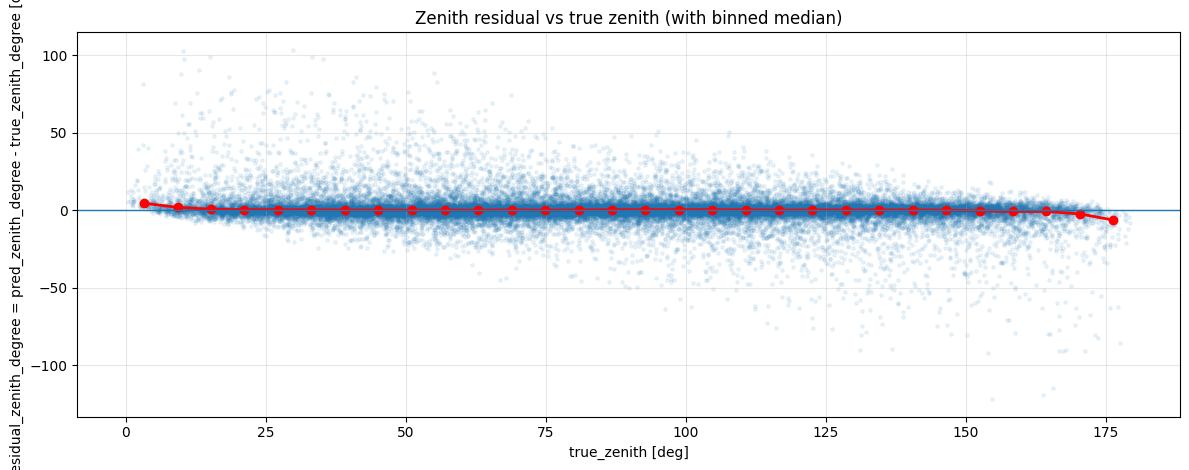

In [ ]:
# ---- Zenith: residual vs true_zenith scatter + binned median (NO subsample) ----

x = df_zenith_test_predictions["true_zenith_degree"].to_numpy(dtype=float)
r = (
    df_zenith_test_predictions["pred_zenith_degree"].to_numpy(dtype=float)
    - df_zenith_test_predictions["true_zenith_degree"].to_numpy(dtype=float)
)

plt.figure(figsize=(12, 4.8))
plt.scatter(x, r, s=6, alpha=0.08)

# binned median (equal-width in x)
n_bins = 30
bins = np.linspace(x.min(), x.max(), n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

median_r = []
for left, right in zip(bins[:-1], bins[1:]):
    m = (x >= left) & (x < right) if right != bins[-1] else (x >= left) & (x <= right)
    median_r.append(np.median(r[m]) if np.any(m) else np.nan)

median_r = np.array(median_r, dtype=float)

plt.plot(bin_centers, median_r, marker="o", linewidth=2, color="r")
plt.axhline(0.0, linestyle="-", linewidth=1)

plt.xlabel("true_zenith [deg]")
plt.ylabel("residual_zenith_degree = pred_zenith_degree - true_zenith_degree [deg]")
plt.title("Zenith residual vs true zenith (with binned median)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Calibration scatter (predicted vs true)

A calibration plot compares the model prediction to the truth directly:

- x-axis: $\theta_\mathrm{true}$ (zenith in **radians**)  
- y-axis: $\widehat{\theta}$ (predicted zenith in **radians**)

The reference line $y=x$ corresponds to perfect calibration.
Points below the line indicate underestimation; above the line indicate overestimation.


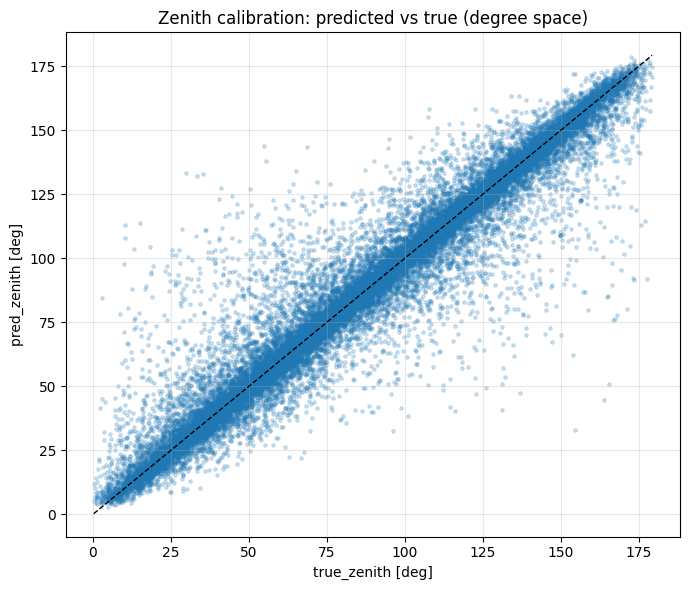

In [ ]:
# ---- Zenith: calibration scatter (pred_zenith vs true_zenith) ----

plt.figure(figsize=(7, 6))

plt.scatter(
    df_zenith_test_predictions["true_zenith_degree"],
    df_zenith_test_predictions["pred_zenith_degree"],
    s=6, alpha=0.2
)

xmin = df_zenith_test_predictions["true_zenith_degree"].min()
xmax = df_zenith_test_predictions["true_zenith_degree"].max()

plt.plot([xmin, xmax], [xmin, xmax], color="black", linestyle="--", linewidth=1)  # y=x

plt.xlabel("true_zenith [deg]")
plt.ylabel("pred_zenith [deg]")
plt.title("Zenith calibration: predicted vs true (degree space)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


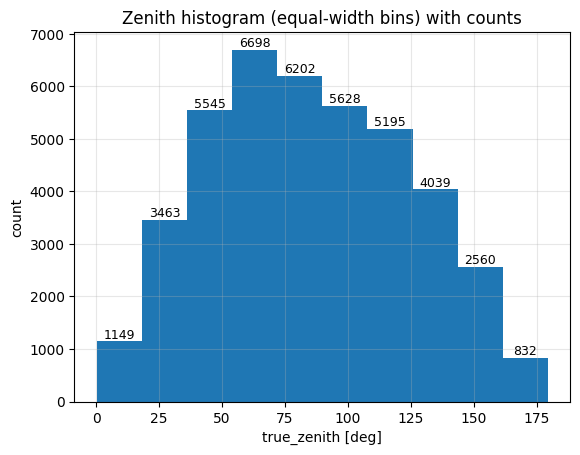

In [ ]:
# ---- Zenith: histogram with counts annotated on top of bars ----
n_bins_zenith = 10
bins_zenith = np.linspace(
    df_zenith_test_predictions["true_zenith_degree"].min(),
    df_zenith_test_predictions["true_zenith_degree"].max(),
    n_bins_zenith + 1,
)
values = df_zenith_test_predictions["true_zenith_degree"].to_numpy(dtype=float)

plt.figure()
counts, edges, patches = plt.hist(values, bins=bins_zenith)

# annotate each bar with its count
for c, left, right in zip(counts, edges[:-1], edges[1:]):
    if c <= 0:
        continue
    x = 0.5 * (left + right)
    plt.text(x, c, f"{int(c)}", ha="center", va="bottom", fontsize=9)

plt.xlabel("true_zenith [deg]")
plt.ylabel("count")
plt.title("Zenith histogram (equal-width bins) with counts")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# ---- Zenith: W table per zenith bin (using residual_zenith in radians) ----

df_zenith_w_rows = []

# residual in radians
residual_zenith = (
    df_zenith_test_predictions["pred_zenith_degree"].to_numpy(dtype=float)
    - df_zenith_test_predictions["true_zenith_degree"].to_numpy(dtype=float)
)

# Use histogram edges from your zenith hist cell:
# counts, edges, patches = plt.hist(...)
# If your variable name is edges_zenith, replace edges -> edges_zenith below.
for left, right in zip(edges[:-1], edges[1:]):
    # match matplotlib hist logic: [left, right) except last bin includes right
    if right == edges[-1]:
        mask = (df_zenith_test_predictions["true_zenith_degree"] >= left) & (df_zenith_test_predictions["true_zenith_degree"] <= right)
    else:
        mask = (df_zenith_test_predictions["true_zenith_degree"] >= left) & (df_zenith_test_predictions["true_zenith_degree"] < right)

    r = residual_zenith[mask.to_numpy()]

    if r.size == 0:
        continue

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (left + right)

    df_zenith_w_rows.append({
        "Zbin": f"({left:.3f}, {right:.3f}]",
        "Z_center_deg": center,
        "count": int(r.size),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,  # radians
    })

df_zenith_W_table = pd.DataFrame(df_zenith_w_rows)
df_zenith_W_table


,Zbin,Z_center_deg,count,p16,p50,p84,W
0,"(0.318, 18.220]",9.268746,1149,-1.817660,1.485742,10.954860,6.386260
1,"(18.220, 36.121]",27.170339,3463,-2.628361,0.350587,6.017208,4.322784
2,"(36.121, 54.023]",45.071933,5545,-2.633780,0.150548,3.887056,3.260418
3,"(54.023, 71.924]",62.973526,6698,-2.539630,0.160878,3.380269,2.959949
4,"(71.924, 89.826]",80.875120,6202,-2.505118,0.219495,3.300328,2.902723
5,"(89.826, 107.728]",98.776713,5628,-2.912440,0.392999,3.418236,3.165338
6,"(107.728, 125.629]",116.678307,5195,-3.253279,0.228880,3.317249,3.285264
7,"(125.629, 143.531]",134.579900,4039,-4.368639,0.213006,3.366516,3.867577
8,"(143.531, 161.432]",152.481494,2560,-6.808464,-0.234146,3.189663,4.999064
9,"(161.432, 179.334]",170.383087,832,-12.745214,-1.901825,2.101168,7.423191


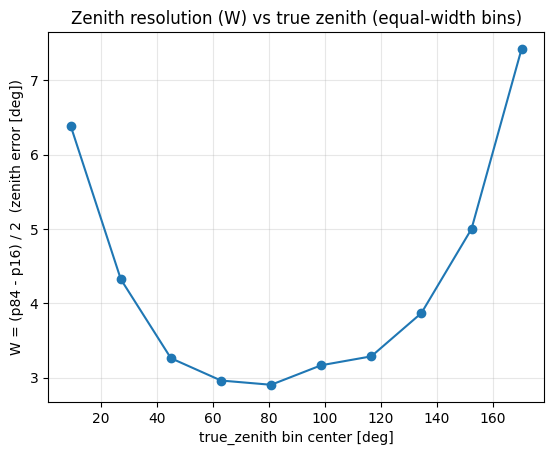

In [ ]:
# ---- Zenith: plot W vs true zenith (equal-width bins) ----

plt.figure()
plt.plot(df_zenith_W_table["Z_center_deg"], df_zenith_W_table["W"], marker="o")
plt.xlabel("true_zenith bin center [deg]")
plt.ylabel("W = (p84 - p16) / 2  (zenith error [deg])")
plt.title("Zenith resolution (W) vs true zenith (equal-width bins)")
plt.grid(True, alpha=0.3)
plt.show()


### Interpreting the W trend (equal-width bins)

In the **equal-width** zenith binning, the number of events per bin is **not uniform**.  
Depending on the underlying event distribution, some zenith regions may contain **much fewer events**, so the quantile estimates (p16/p50/p84) become **statistically unstable**. This can artificially inflate the width  
$W = (p84 - p16)/2$ and make it look like the resolution worsens in those zenith ranges.

To reduce this sampling effect, we next repeat the same analysis using **equal-population bins** (i.e., bins with approximately the same number of events) and compare the results.


In [ ]:
# ---- create equal-population bins (qcut) ----

n_qbins_zenith = 10

df_zenith_test_predictions["Zbin_q"] = pd.qcut(
    df_zenith_test_predictions["true_zenith_degree"],
    q=n_qbins_zenith,
    duplicates="drop",
)


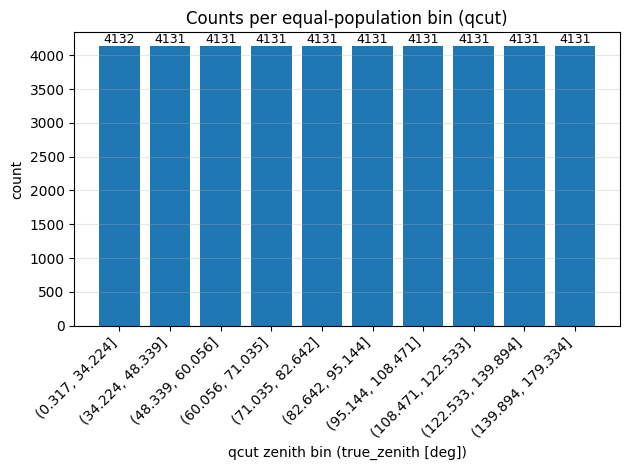

In [ ]:
# ---- plot counts per qcut bin ----

bin_counts_q = df_zenith_test_predictions["Zbin_q"].value_counts().sort_index()

plt.figure()
plt.bar(range(len(bin_counts_q)), bin_counts_q.to_numpy())
plt.xticks(
    range(len(bin_counts_q)),
    [str(i) for i in bin_counts_q.index],
    rotation=45,
    ha="right",
)
plt.xlabel("qcut zenith bin (true_zenith [deg])")
plt.ylabel("count")
plt.title("Counts per equal-population bin (qcut)")
plt.grid(True, axis="y", alpha=0.3)

# annotate counts on top of bars
for i, c in enumerate(bin_counts_q.to_numpy()):
    plt.text(i, c, str(int(c)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


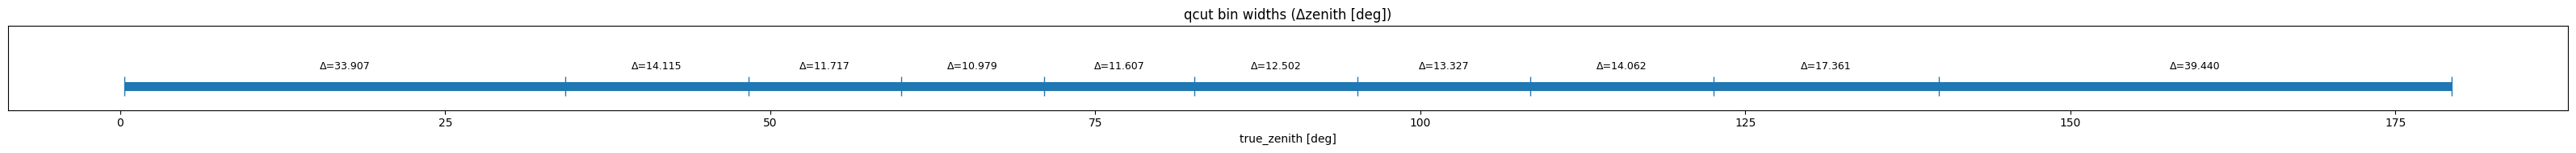

In [ ]:
# ---- Visualize qcut bin widths only (in zenith radian space) ----

# intervals in correct order
intervals = bin_counts_q.index  # IntervalIndex from your existing bin_counts_q

lefts  = np.array([iv.left for iv in intervals], dtype=float)
rights = np.array([iv.right for iv in intervals], dtype=float)
widths = rights - lefts
centers = (lefts + rights) / 2

plt.figure(figsize=(32, 2))

# draw each bin as a horizontal segment
for L, R, w, x in zip(lefts, rights, widths, centers):
    plt.hlines(0, L, R, linewidth=8)
    plt.text(x, 0.12, f"Δ={w:.3f}", ha="center", va="bottom", fontsize=9)

# draw bin boundaries as small ticks
for x in lefts:
    plt.vlines(x, -0.08, 0.08, linewidth=1)
plt.vlines(rights[-1], -0.08, 0.08, linewidth=1)

plt.yticks([])
plt.xlabel("true_zenith [deg]")
plt.title("qcut bin widths (Δzenith [deg])")
plt.ylim(-0.2, 0.5)
plt.tight_layout()
plt.show()


In [ ]:
# ---- Zenith: p16/p50/p84 and W per qcut bin (use groupby directly; no remasking) ----

rows_zenith_q = []
for iv, g in df_zenith_test_predictions.groupby("Zbin_q", observed=True):
    r = (g["pred_zenith_degree"] - g["true_zenith_degree"]).to_numpy(dtype=float)  # residual in radians

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (float(iv.left) + float(iv.right))

    rows_zenith_q.append({
        "Zbin_q": str(iv),
        "Z_center_deg": center,
        "count": int(len(g)),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,  # radians
    })

df_zenith_W_table_q = pd.DataFrame(rows_zenith_q).sort_values("Z_center_deg")
df_zenith_W_table_q


,Zbin_q,Z_center_deg,count,p16,p50,p84,W
0,"(0.317, 34.224]",17.2705,4132,-2.369894,0.661538,7.326677,4.848286
1,"(34.224, 48.339]",41.2815,4131,-2.630031,0.170488,4.087710,3.358871
2,"(48.339, 60.056]",54.1975,4131,-2.669720,0.155995,3.692447,3.181084
3,"(60.056, 71.035]",65.5455,4131,-2.506614,0.164526,3.346164,2.926389
4,"(71.035, 82.642]",76.8385,4131,-2.455626,0.138974,3.116714,2.786170
5,"(82.642, 95.144]",88.8930,4131,-2.694807,0.361317,3.438887,3.066847
6,"(95.144, 108.471]",101.8075,4131,-3.054092,0.404375,3.485129,3.269610
7,"(108.471, 122.533]",115.5020,4131,-3.200647,0.232595,3.346552,3.273600
8,"(122.533, 139.894]",131.2135,4131,-4.164000,0.174962,3.304997,3.734499
9,"(139.894, 179.334]",159.6140,4131,-7.494655,-0.330472,3.030793,5.262724


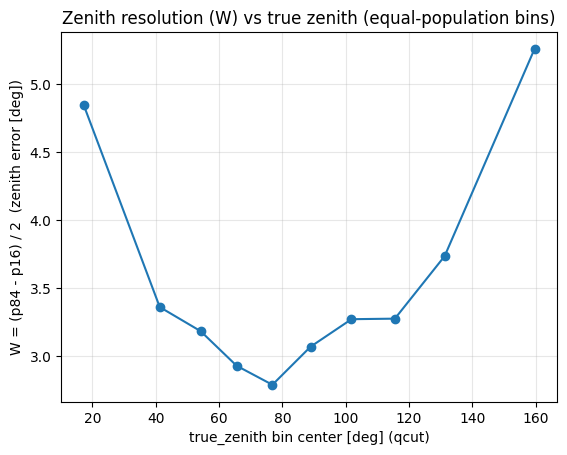

In [ ]:
# ---- Zenith: plot W vs true zenith (qcut bins) ----

plt.figure()
plt.plot(df_zenith_W_table_q["Z_center_deg"], df_zenith_W_table_q["W"], marker="o")
plt.xlabel("true_zenith bin center [deg] (qcut)")
plt.ylabel("W = (p84 - p16) / 2  (zenith error [deg])")
plt.title("Zenith resolution (W) vs true zenith (equal-population bins)")
plt.grid(True, alpha=0.3)
plt.show()


#### Definition of `residual_zenith` (degrees)

`residual_zenith_degree` is defined as:

$$
\mathrm{residual\_zenith\_degree}
=
\hat{\theta}_{\mathrm{zenith}}^{(\deg)}
-
\theta_{\mathrm{zenith,true}}^{(\deg)}
$$

In the CSV this corresponds to:

$$
\mathrm{residual\_zenith\_degree}
=
\mathrm{pred\_zenith\_degree}
-
\mathrm{true\_zenith\_degree}
$$



#### Interpreting the sign of `residual_zenith_degree`

- `residual_zenith_degree = 0` → perfect prediction  
- `residual_zenith_degree > 0` → the model predicts a **larger zenith angle** than truth  
- `residual_zenith_degree < 0` → the model predicts a **smaller zenith angle** than truth  

**Note:** Zenith is not periodic like azimuth, so a simple difference usually makes sense.  
Typical range: $\theta_{\deg} \in [0,180^\circ]$  
$\Rightarrow$ residual roughly in $[-180^\circ, 180^\circ]$.



#### Quantiles: p16, p50, p84

To summarize the distribution of `residual_zenith_degree`:

- **p50** = median (middle value) → can be interpreted as **bias**
- **p16** and **p84** = the 16th and 84th percentiles  
  (If residuals were Gaussian, these would roughly correspond to $\pm 1\sigma$ around the median.)



#### Resolution proxy: `W`

I define a resolution-like width using the central 68% interval:

$W = \frac{p84 - p16}{2}$

Interpretation:

- Small $W$ → tighter residual distribution → **better resolution**
- Large $W$ → wider residual distribution → **worse resolution**


#### Zenith performance so far: resolution (W)

So far we focused on **resolution**, summarized by  
$W = (p84 - p16)/2$, computed from the **zenith residual** distribution  
$r = \widehat{\theta} - \theta_\mathrm{true}$ in each zenith bin (units: **angles**).

Resolution tells us **how wide** the error distribution is.

Next, we examine **bias**:  
Does the model systematically **overestimate** or **underestimate** the zenith angle, and does this depend on zenith?


#### Bias analysis — three complementary views

There are three simple and complementary ways to study bias:

1) **Median residual vs zenith**  
   Plot $p50(r)$ as a function of zenith, where  
   $r = \widehat{\theta} - \theta_\mathrm{true}$ (angles).  
   This is the most direct bias measure in angular space.

2) **Median absolute error vs zenith**  
   Plot the median of the absolute error (e.g., $p50(|r|)$ in degrees).  
   This makes the typical angular deviation easier to interpret than signed residuals.



### 1) Median residual vs zenith (angular bias)

If we define the zenith residual (in degrees) as  
$r = \widehat{\theta} - \theta_\mathrm{true}$,

then:

- $p50 \approx 0$ → unbiased in that zenith region  
- $p50 > 0$ → systematic overestimation of zenith  
- $p50 < 0$ → systematic underestimation of zenith


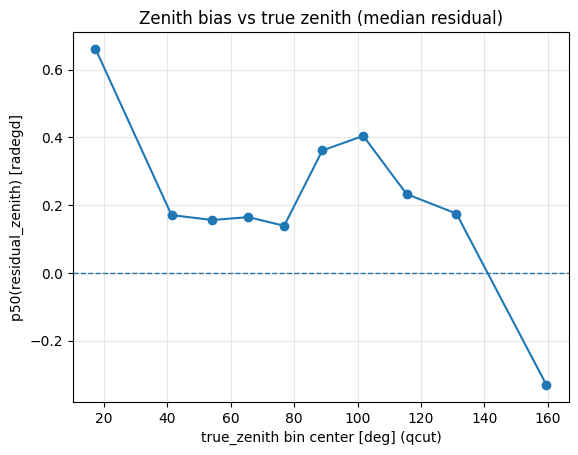

In [ ]:
# ---- Zenith: bias vs true zenith (median residual, qcut bins) ----

plt.figure()
plt.plot(df_zenith_W_table_q["Z_center_deg"], df_zenith_W_table_q["p50"], marker="o")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("true_zenith bin center [deg] (qcut)")
plt.ylabel("p50(residual_zenith) [radegd]")
plt.title("Zenith bias vs true zenith (median residual)")
plt.grid(True, alpha=0.3)
plt.show()


### 2) Median absolute error vs zenith (intuitive)

Because the signed residual can cancel out, it is also useful to track the typical *magnitude* of the error:

- $p50(|r|)$ in **degrees** 

Interpretation:
- smaller values → better angular accuracy
- larger values → worse angular accuracy in that zenith region


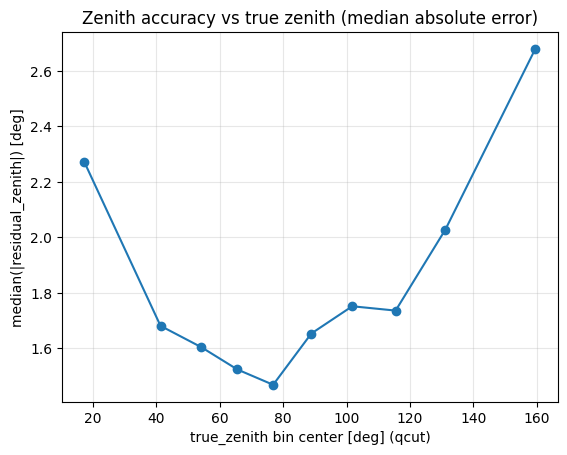

In [ ]:
# ---- Zenith: median absolute error vs true zenith (qcut bins) ----

df_zenith_W_table_q["abs_p50_deg"] = np.nan  # keep style similar to your energy table edits

abs_rows = []
for iv, g in df_zenith_test_predictions.groupby("Zbin_q", observed=True):
    r = (g["pred_zenith_degree"] - g["true_zenith_degree"]).to_numpy(dtype=float)
    abs_rows.append((str(iv), np.median(np.abs(r))))

abs_map = dict(abs_rows)
df_zenith_W_table_q["abs_p50_deg"] = df_zenith_W_table_q["Zbin_q"].map(abs_map)

plt.figure()
plt.plot(df_zenith_W_table_q["Z_center_deg"], df_zenith_W_table_q["abs_p50_deg"], marker="o")
plt.xlabel("true_zenith bin center [deg] (qcut)")
plt.ylabel("median(|residual_zenith|) [deg]")
plt.title("Zenith accuracy vs true zenith (median absolute error)")
plt.grid(True, alpha=0.3)
plt.show()


### 1.c) Azimuth

Flow:
1) Confirm columns / NaNs / Infs.
2) Look at the global residual histogram.
3) Check residual vs true energy (trend + spread).
4) Quantify resolution with **W** (both equal-width and equal-population bins).
5) Assess bias with median residual and pred/true ratio.


In [ ]:
print("shape:", df_azimuth_test_predictions.shape)
print("columns:", list(df_azimuth_test_predictions.columns))

shape: (41311, 5)
columns: ['true_azimuth', 'pred_azimuth', 'abs_error_deg', 'kappa', 'event_id']


In [ ]:
numeric_cols = df_azimuth_test_predictions.select_dtypes(include=[np.number]).columns
minmax = df_azimuth_test_predictions[numeric_cols].agg(["min", "max"]).T

print(minmax)


                     min            max
true_azimuth    0.000005       6.282984
pred_azimuth    0.000081       6.283109
abs_error_deg   0.000096     179.967850
kappa           0.019750     146.429672
event_id       18.000000  402910.000000


##### Column ranges (min / max)

The table above reports the **minimum** and **maximum** value observed in each **numeric** column of `df_azimuth_test_predictions`.

**Units**
- `true_azimuth` and `pred_azimuth` are in **radians** (expected physical range: \[0, 2π\]).
- `abs_error_deg` is in **degrees**.
- `kappa` is **dimensionless** (concentration parameter).
- `event_id` is an **integer identifier** (unitless).

In [ ]:
# --- 1) Rename radian columns to make units explicit ---
rename_map = {
    "true_azimuth": "true_azimuth_radian",
    "pred_azimuth": "pred_azimuth_radian",
    "kappa": "kappa",          # unchanged (unitless)
    "event_id": "event_id",    # unchanged
    "abs_error_deg": "abs_error_azimuth_degree",  # already in degrees
}
df_azimuth_test_predictions.rename(columns={k: v for k, v in rename_map.items() if k in df_azimuth_test_predictions.columns}, inplace=True)

# --- 2) Compute signed residual in radians ---
df_azimuth_test_predictions["residual_azimuth_radian"] = df_azimuth_test_predictions["pred_azimuth_radian"] - df_azimuth_test_predictions["true_azimuth_radian"]

# --- 3) Create degree versions ---
rad2deg = 180.0 / np.pi
df_azimuth_test_predictions["true_azimuth_degree"] = df_azimuth_test_predictions["true_azimuth_radian"] * rad2deg
df_azimuth_test_predictions["pred_azimuth_degree"] = df_azimuth_test_predictions["pred_azimuth_radian"] * rad2deg
df_azimuth_test_predictions["residual_azimuth_degree"] = df_azimuth_test_predictions["residual_azimuth_radian"] * rad2deg

# Optional: also keep abs error in radians (consistent pair with abs_error_azimuth_degree)
df_azimuth_test_predictions["abs_error_azimuth_radian"] = np.abs(df_azimuth_test_predictions["residual_azimuth_radian"])

# abs error of azimuth angle in radians (|pred - true|)
df_azimuth_test_predictions["abs_error_azimuth_radian"] = np.abs(
    df_azimuth_test_predictions["pred_azimuth_radian"] - df_azimuth_test_predictions["true_azimuth_radian"]
)

# quick check
print("columns:", list(df_azimuth_test_predictions.columns))
df_azimuth_test_predictions.head()


columns: ['true_azimuth_radian', 'pred_azimuth_radian', 'abs_error_azimuth_degree', 'kappa', 'event_id', 'residual_azimuth_radian', 'true_azimuth_degree', 'pred_azimuth_degree', 'residual_azimuth_degree', 'abs_error_azimuth_radian']


,true_azimuth_radian,pred_azimuth_radian,abs_error_azimuth_degree,kappa,event_id,residual_azimuth_radian,true_azimuth_degree,pred_azimuth_degree,residual_azimuth_degree,abs_error_azimuth_radian
0,4.139313,5.064487,53.008568,1.136127,242,0.925174,237.165150,290.173702,53.008552,0.925174
1,5.674534,5.687032,0.716077,94.627869,778,0.012498,325.126840,325.842917,0.716077,0.012498
2,1.370334,1.532587,9.296420,80.640984,1171,0.162253,78.514377,87.810790,9.296413,0.162253
3,6.200981,6.147312,3.075006,53.473114,1634,-0.053669,355.290048,352.215042,-3.075006,0.053669
4,4.743681,4.357677,22.116398,38.986622,3741,-0.386004,271.792898,249.676500,-22.116398,0.386004


In [ ]:
print("Rows:", len(df_azimuth_test_predictions))

print("\nNaN counts (all columns):")
print(df_azimuth_test_predictions.isna().sum())


Rows: 41311

NaN counts (all columns):
true_azimuth_radian         0
pred_azimuth_radian         0
abs_error_azimuth_degree    0
kappa                       0
event_id                    0
residual_azimuth_radian     0
true_azimuth_degree         0
pred_azimuth_degree         0
residual_azimuth_degree     0
abs_error_azimuth_radian    0
dtype: int64


In [ ]:
# Inf / -Inf counts in numeric columns (auto)
num_df = df_azimuth_test_predictions.apply(pd.to_numeric, errors="coerce")

inf_pos = np.isposinf(num_df).sum()
inf_neg = np.isneginf(num_df).sum()
inf_any = np.isinf(num_df).sum()

out = pd.DataFrame({
    "+inf": inf_pos,
    "-inf": inf_neg,
    "any_inf": inf_any
}).sort_values("any_inf", ascending=False)

print("Inf counts (numeric columns):")
print(out)


Inf counts (numeric columns):
                          +inf  -inf  any_inf
true_azimuth_radian          0     0        0
pred_azimuth_radian          0     0        0
abs_error_azimuth_degree     0     0        0
kappa                        0     0        0
event_id                     0     0        0
residual_azimuth_radian      0     0        0
true_azimuth_degree          0     0        0
pred_azimuth_degree          0     0        0
residual_azimuth_degree      0     0        0
abs_error_azimuth_radian     0     0        0


#### Azimuth overview

In [ ]:
# ---- Energy: global W over the full test set ----
r = df_azimuth_test_predictions["residual_azimuth_degree"].to_numpy(dtype=float)
p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
W = (p84 - p16) / 2

print(f"p16={p16:.4f}, p50={p50:.4f}, p84={p84:.4f}, W={W:.4f}")

p16=-5.5761, p50=0.1607, p84=5.8938, W=5.7350


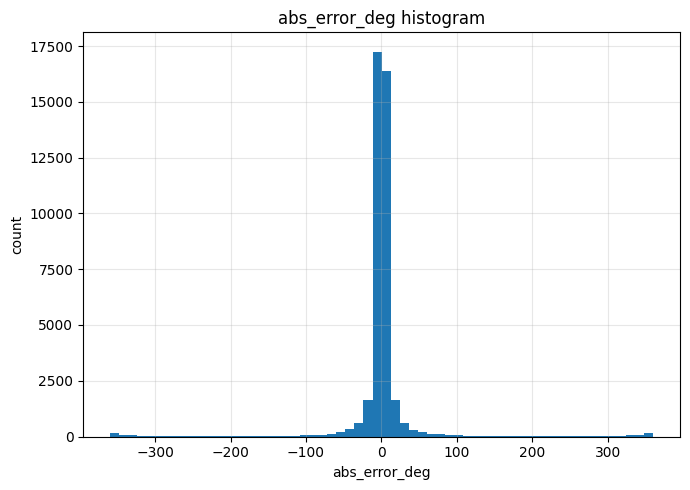

In [ ]:
# ---- abs_error_deg histogram (full test set) ----

plt.figure(figsize=(7, 5))
plt.hist(r, bins=60)
plt.xlabel("abs_error_deg")
plt.ylabel("count")
plt.title("abs_error_deg histogram")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

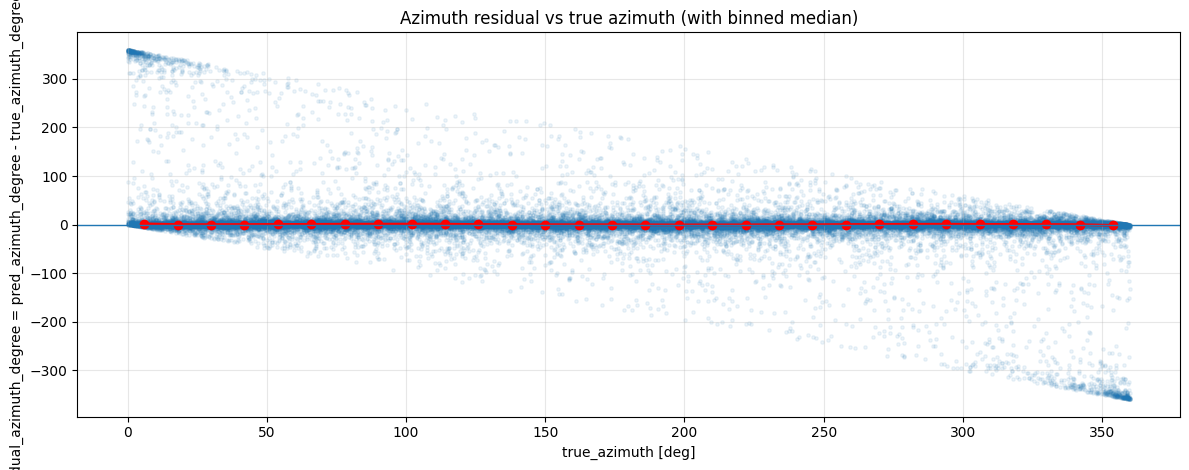

In [ ]:
# ---- Azimuth: residual vs true_azimuth scatter + binned median (NO subsample) ----

x = df_azimuth_test_predictions["true_azimuth_degree"].to_numpy(dtype=float)
r = (
    df_azimuth_test_predictions["pred_azimuth_degree"].to_numpy(dtype=float)
    - df_azimuth_test_predictions["true_azimuth_degree"].to_numpy(dtype=float)
)

plt.figure(figsize=(12, 4.8))
plt.scatter(x, r, s=6, alpha=0.08)

# binned median (equal-width in x)
n_bins = 30
bins = np.linspace(x.min(), x.max(), n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

median_r = []
for left, right in zip(bins[:-1], bins[1:]):
    m = (x >= left) & (x < right) if right != bins[-1] else (x >= left) & (x <= right)
    median_r.append(np.median(r[m]) if np.any(m) else np.nan)

median_r = np.array(median_r, dtype=float)

plt.plot(bin_centers, median_r, marker="o", linewidth=2, color="r")
plt.axhline(0.0, linestyle="-", linewidth=1)

plt.xlabel("true_azimuth [deg]")
plt.ylabel("residual_azimuth_degree = pred_azimuth_degree - true_azimuth_degree [deg]")
plt.title("Azimuth residual vs true azimuth (with binned median)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


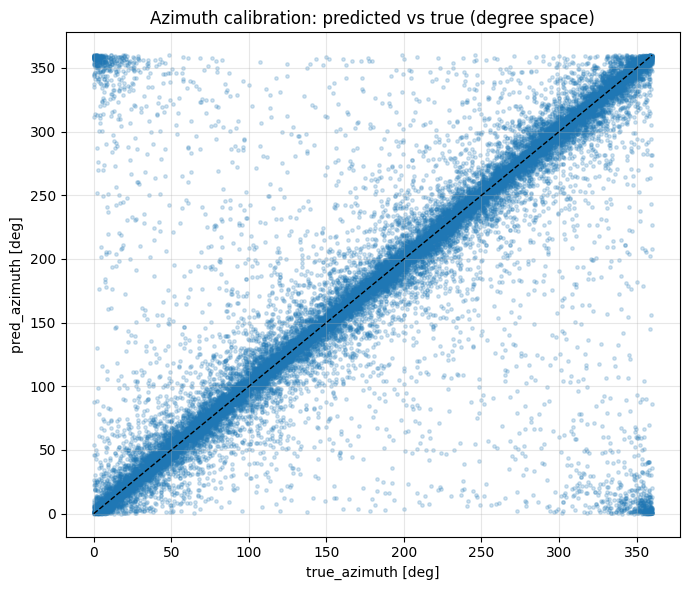

In [ ]:
# ---- Azimuth: calibration scatter (pred_azimuth vs true_azimuth) ----

plt.figure(figsize=(7, 6))

plt.scatter(
    df_azimuth_test_predictions["true_azimuth_degree"],
    df_azimuth_test_predictions["pred_azimuth_degree"],
    s=6, alpha=0.2
)

xmin = df_azimuth_test_predictions["true_azimuth_degree"].min()
xmax = df_azimuth_test_predictions["true_azimuth_degree"].max()

plt.plot([xmin, xmax], [xmin, xmax], color="black", linestyle="--", linewidth=1)  # y=x

plt.xlabel("true_azimuth [deg]")
plt.ylabel("pred_azimuth [deg]")
plt.title("Azimuth calibration: predicted vs true (degree space)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


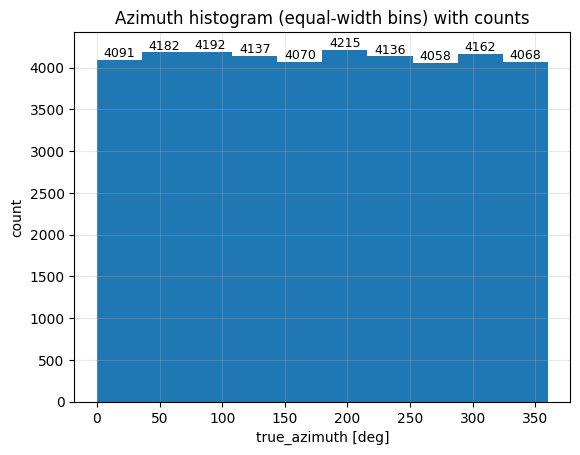

In [ ]:
# ---- Azimuth: histogram with counts annotated on top of bars ----
n_bins_azimuth = 10
bins_azimuth = np.linspace(
    df_azimuth_test_predictions["true_azimuth_degree"].min(),
    df_azimuth_test_predictions["true_azimuth_degree"].max(),
    n_bins_azimuth + 1,
)
values = df_azimuth_test_predictions["true_azimuth_degree"].to_numpy(dtype=float)

plt.figure()
counts, edges, patches = plt.hist(values, bins=bins_azimuth)

# annotate each bar with its count
for c, left, right in zip(counts, edges[:-1], edges[1:]):
    if c <= 0:
        continue
    x = 0.5 * (left + right)
    plt.text(x, c, f"{int(c)}", ha="center", va="bottom", fontsize=9)

plt.xlabel("true_azimuth [deg]")
plt.ylabel("count")
plt.title("Azimuth histogram (equal-width bins) with counts")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# ---- Azimuth: W table per azimuth bin (using residual_azimuth in radians) ----

df_azimuth_w_rows = []

# residual in radians
residual_azimuth = (
    df_azimuth_test_predictions["pred_azimuth_degree"].to_numpy(dtype=float)
    - df_azimuth_test_predictions["true_azimuth_degree"].to_numpy(dtype=float)
)

# Use histogram edges from your azimuth hist cell:
# counts, edges, patches = plt.hist(...)
# If your variable name is edges_azimuth, replace edges -> edges_azimuth below.
for left, right in zip(edges[:-1], edges[1:]):
    # match matplotlib hist logic: [left, right) except last bin includes right
    if right == edges[-1]:
        mask = (df_azimuth_test_predictions["true_azimuth_degree"] >= left) & (df_azimuth_test_predictions["true_azimuth_degree"] <= right)
    else:
        mask = (df_azimuth_test_predictions["true_azimuth_degree"] >= left) & (df_azimuth_test_predictions["true_azimuth_degree"] < right)

    r = residual_azimuth[mask.to_numpy()]

    if r.size == 0:
        continue

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (left + right)

    df_azimuth_w_rows.append({
        "Abin": f"({left:.3f}, {right:.3f}]",
        "A_center_deg": center,
        "count": int(r.size),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,  # radians
    })

df_azimuth_W_table = pd.DataFrame(df_azimuth_w_rows)
df_azimuth_W_table


,Abin,A_center_deg,count,p16,p50,p84,W
0,"(0.000, 35.999]",17.999692,4091,-3.032475,0.503812,21.498737,12.265606
1,"(35.999, 71.998]",53.998512,4182,-4.544302,0.298312,6.997379,5.770840
2,"(71.998, 107.997]",89.997332,4192,-4.089524,0.935521,7.272762,5.681143
3,"(107.997, 143.996]",125.996151,4137,-4.657063,0.410809,6.091930,5.374497
4,"(143.996, 179.994]",161.994971,4070,-5.523134,-0.225314,5.360556,5.441845
5,"(179.994, 215.993]",197.993791,4215,-6.623910,-0.539202,5.171989,5.897949
6,"(215.993, 251.992]",233.992611,4136,-6.777479,-0.312987,5.559665,6.168572
7,"(251.992, 287.991]",269.991431,4058,-5.628913,0.405262,5.189052,5.408983
8,"(287.991, 323.990]",305.990251,4162,-7.038448,0.552945,5.027563,6.033006
9,"(323.990, 359.988]",341.989071,4068,-19.586772,-0.492607,3.100860,11.343816


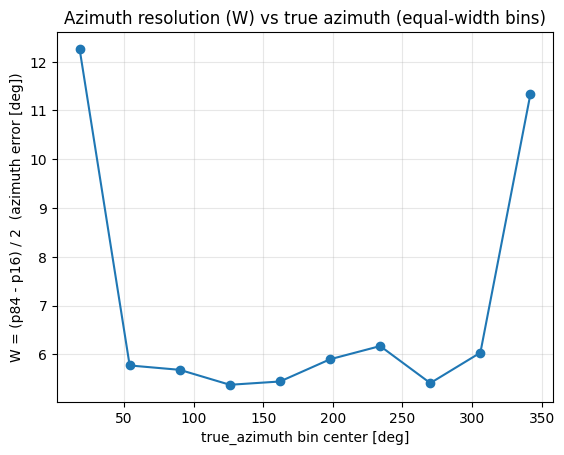

In [ ]:
# ---- Azimuth: plot W vs true azimuth (equal-width bins) ----

plt.figure()
plt.plot(df_azimuth_W_table["A_center_deg"], df_azimuth_W_table["W"], marker="o")
plt.xlabel("true_azimuth bin center [deg]")
plt.ylabel("W = (p84 - p16) / 2  (azimuth error [deg])")
plt.title("Azimuth resolution (W) vs true azimuth (equal-width bins)")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# ---- create equal-population bins (qcut) ----

n_qbins_azimuth = 10

df_azimuth_test_predictions["Abin_q"] = pd.qcut(
    df_azimuth_test_predictions["true_azimuth_degree"],
    q=n_qbins_azimuth,
    duplicates="drop",
)


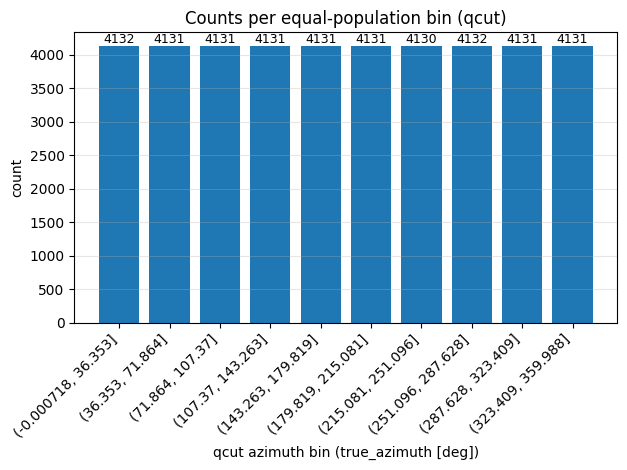

In [ ]:
# ---- plot counts per qcut bin ----

bin_counts_q = df_azimuth_test_predictions["Abin_q"].value_counts().sort_index()

plt.figure()
plt.bar(range(len(bin_counts_q)), bin_counts_q.to_numpy())
plt.xticks(
    range(len(bin_counts_q)),
    [str(i) for i in bin_counts_q.index],
    rotation=45,
    ha="right",
)
plt.xlabel("qcut azimuth bin (true_azimuth [deg])")
plt.ylabel("count")
plt.title("Counts per equal-population bin (qcut)")
plt.grid(True, axis="y", alpha=0.3)

# annotate counts on top of bars
for i, c in enumerate(bin_counts_q.to_numpy()):
    plt.text(i, c, str(int(c)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


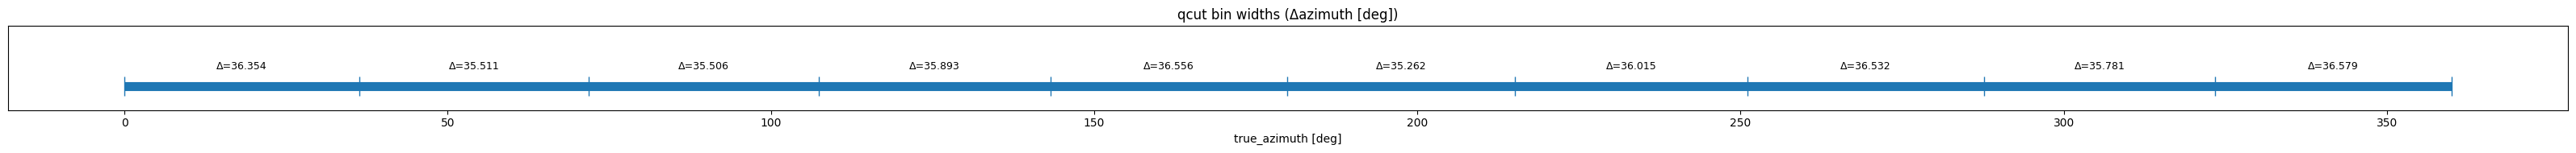

In [ ]:
# ---- Visualize qcut bin widths only (in azimuth radian space) ----

# intervals in correct order
intervals = bin_counts_q.index  # IntervalIndex from your existing bin_counts_q

lefts  = np.array([iv.left for iv in intervals], dtype=float)
rights = np.array([iv.right for iv in intervals], dtype=float)
widths = rights - lefts
centers = (lefts + rights) / 2

plt.figure(figsize=(32, 2))

# draw each bin as a horizontal segment
for L, R, w, x in zip(lefts, rights, widths, centers):
    plt.hlines(0, L, R, linewidth=8)
    plt.text(x, 0.12, f"Δ={w:.3f}", ha="center", va="bottom", fontsize=9)

# draw bin boundaries as small ticks
for x in lefts:
    plt.vlines(x, -0.08, 0.08, linewidth=1)
plt.vlines(rights[-1], -0.08, 0.08, linewidth=1)

plt.yticks([])
plt.xlabel("true_azimuth [deg]")
plt.title("qcut bin widths (Δazimuth [deg])")
plt.ylim(-0.2, 0.5)
plt.tight_layout()
plt.show()


In [ ]:
# ---- Azimuth: p16/p50/p84 and W per qcut bin (use groupby directly; no remasking) ----

rows_azimuth_q = []
for iv, g in df_azimuth_test_predictions.groupby("Abin_q", observed=True):
    r = (g["pred_azimuth_degree"] - g["true_azimuth_degree"]).to_numpy(dtype=float)  # residual in radians

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (float(iv.left) + float(iv.right))

    rows_azimuth_q.append({
        "Abin_q": str(iv),
        "A_center_deg": center,
        "count": int(len(g)),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,  # radians
    })

df_azimuth_W_table_q = pd.DataFrame(rows_azimuth_q).sort_values("A_center_deg")
df_azimuth_W_table_q


,Abin_q,A_center_deg,count,p16,p50,p84,W
0,"(-0.000718, 36.353]",18.176141,4132,-3.052353,0.481527,21.129475,12.090914
1,"(36.353, 71.864]",54.108500,4131,-4.543715,0.307707,6.988014,5.765865
2,"(71.864, 107.37]",89.617000,4131,-4.023883,0.932157,7.287812,5.655847
3,"(107.37, 143.263]",125.316500,4131,-4.685876,0.424291,6.156991,5.421433
4,"(143.263, 179.819]",161.541000,4131,-5.475112,-0.195863,5.367021,5.421067
5,"(179.819, 215.081]",197.450000,4131,-6.588417,-0.507565,5.277264,5.932840
6,"(215.081, 251.096]",233.088500,4130,-6.753912,-0.366542,5.454583,6.104247
7,"(251.096, 287.628]",269.362000,4132,-5.684465,0.400263,5.204537,5.444501
8,"(287.628, 323.409]",305.518500,4131,-6.991879,0.565321,5.068902,6.030390
9,"(323.409, 359.988]",341.698500,4131,-19.457296,-0.496965,3.100491,11.278894


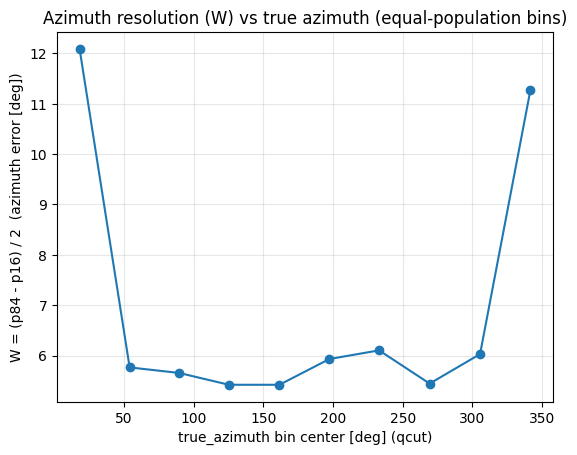

In [ ]:
# ---- Azimuth: plot W vs true azimuth (qcut bins) ----

plt.figure()
plt.plot(df_azimuth_W_table_q["A_center_deg"], df_azimuth_W_table_q["W"], marker="o")
plt.xlabel("true_azimuth bin center [deg] (qcut)")
plt.ylabel("W = (p84 - p16) / 2  (azimuth error [deg])")
plt.title("Azimuth resolution (W) vs true azimuth (equal-population bins)")
plt.grid(True, alpha=0.3)
plt.show()


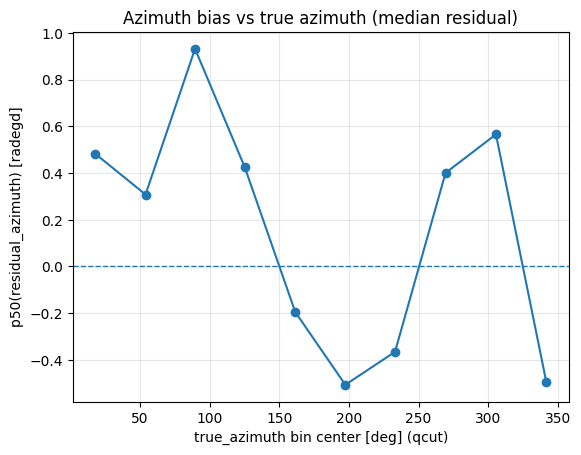

In [ ]:
# ---- Azimuth: bias vs true azimuth (median residual, qcut bins) ----

plt.figure()
plt.plot(df_azimuth_W_table_q["A_center_deg"], df_azimuth_W_table_q["p50"], marker="o")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("true_azimuth bin center [deg] (qcut)")
plt.ylabel("p50(residual_azimuth) [radegd]")
plt.title("Azimuth bias vs true azimuth (median residual)")
plt.grid(True, alpha=0.3)
plt.show()


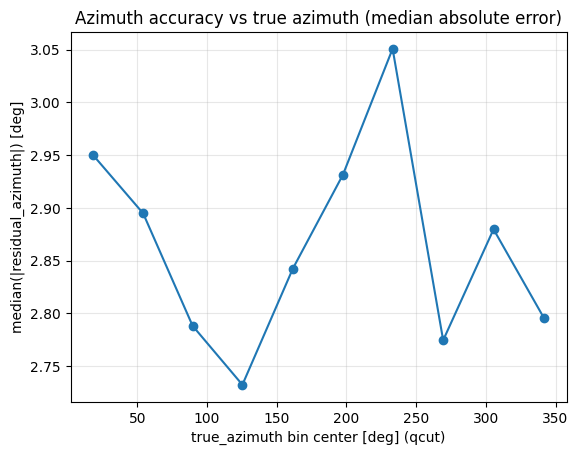

In [ ]:
# ---- Azimuth: median absolute error vs true azimuth (qcut bins) ----

df_azimuth_W_table_q["abs_p50_deg"] = np.nan  # keep style similar to your energy table edits

abs_rows = []
for iv, g in df_azimuth_test_predictions.groupby("Abin_q", observed=True):
    r = (g["pred_azimuth_degree"] - g["true_azimuth_degree"]).to_numpy(dtype=float)
    abs_rows.append((str(iv), np.median(np.abs(r))))

abs_map = dict(abs_rows)
df_azimuth_W_table_q["abs_p50_deg"] = df_azimuth_W_table_q["Abin_q"].map(abs_map)

plt.figure()
plt.plot(df_azimuth_W_table_q["A_center_deg"], df_azimuth_W_table_q["abs_p50_deg"], marker="o")
plt.xlabel("true_azimuth bin center [deg] (qcut)")
plt.ylabel("median(|residual_azimuth|) [deg]")
plt.title("Azimuth accuracy vs true azimuth (median absolute error)")
plt.grid(True, alpha=0.3)
plt.show()


## 2) metrics.csv


### Energy

Train/validation loss curves from `metrics.csv`.


In [ ]:
df_energy_metrics = pd.read_csv(energy_metrics_path)




print("shape:", df_energy_metrics.shape)
print("columns:", list(df_energy_metrics.columns))

shape: (30, 3)
columns: ['epoch', 'train_loss', 'val_loss']


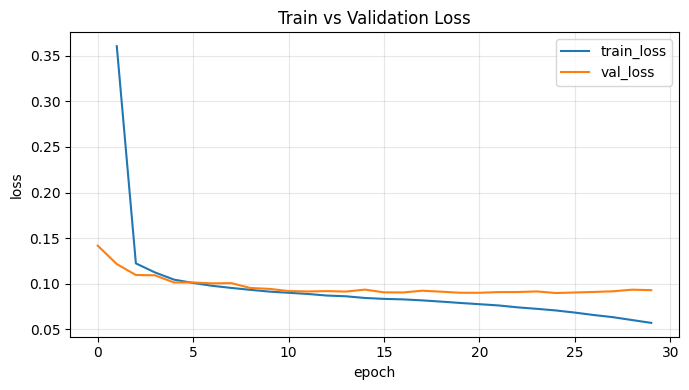

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(df_energy_metrics["epoch"], df_energy_metrics["train_loss"], label="train_loss")
plt.plot(df_energy_metrics["epoch"], df_energy_metrics["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train vs Validation Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Zenith

In [ ]:
df_zenith_metrics = pd.read_csv(zenith_metrics_path)




print("shape:", df_zenith_metrics.shape)
print("columns:", list(df_zenith_metrics.columns))

shape: (30, 3)
columns: ['epoch', 'train_loss', 'val_loss']


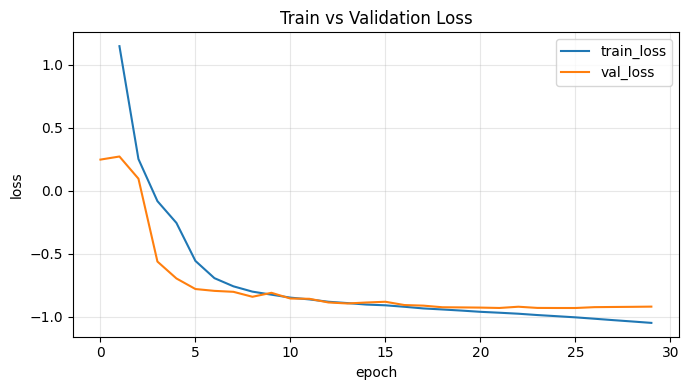

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(df_zenith_metrics["epoch"], df_zenith_metrics["train_loss"], label="train_loss")
plt.plot(df_zenith_metrics["epoch"], df_zenith_metrics["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train vs Validation Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Azimuth

In [ ]:
df_azimuth_metrics = pd.read_csv(azimuth_metrics_path)




print("shape:", df_azimuth_metrics.shape)
print("columns:", list(df_azimuth_metrics.columns))

shape: (30, 3)
columns: ['epoch', 'train_loss', 'val_loss']


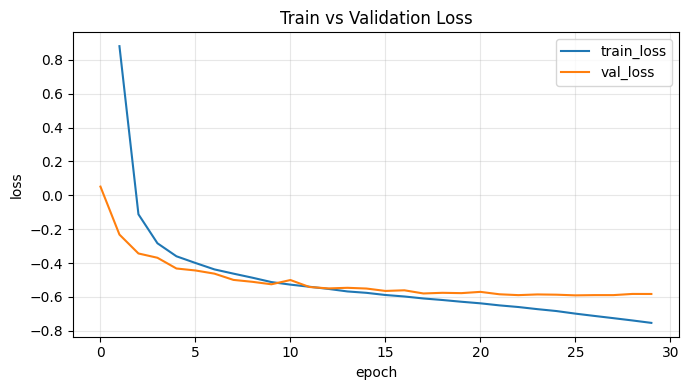

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(df_azimuth_metrics["epoch"], df_azimuth_metrics["train_loss"], label="train_loss")
plt.plot(df_azimuth_metrics["epoch"], df_azimuth_metrics["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train vs Validation Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 3) resources_and_time.csv


### Energy

*(Optional: add runtime / GPU/CPU resource plots here.)*


### Zenith

*(Heading only — fill in later.)*


### Azimuth

*(Heading only — fill in later.)*


## Appendix: Moved scratch / placeholder cells (kept unchanged)

This section contains the original empty cells / duplicate headings / early drafts.
They are kept to ensure **nothing is removed**, but moved out of the main flow.
